# K Nearest Neighbors Modeling

We previously completed modeling using logistic regression, and found our model started to plateau. In this notebook we'll be modeling using K nearest neighbors.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_roc_curve

from src.seed import SEED
from src.helper import praf1, confmat

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load in our data and split it
train = pd.read_csv("../data/processed/train.csv")
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

In [3]:
# account for class imbalance
sm = SMOTENC(np.arange(19, 69), random_state=SEED, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Vanilla KNN

We'll create our baseline KNN model which has no hyper parameter tuning.

In [4]:
# create model fit and predict
knn = KNeighborsClassifier(n_jobs=-1)  # set n_jobs = -1 just for speed
knn.fit(X_train, y_train)

train_pred = knn.predict(X_train)
test_pred = knn.predict(X_test)

In [5]:
# output training and testing results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.995633,0.853400,0.924828,0.919046
Testing,0.562500,0.098901,0.857600,0.168224


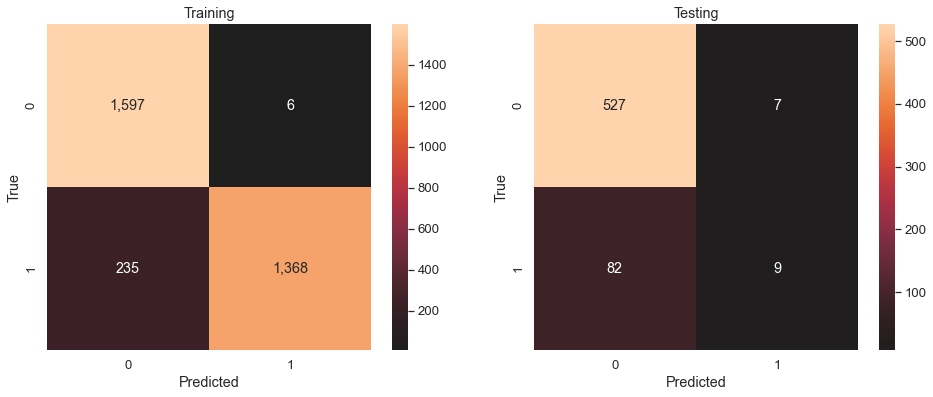

In [6]:
# output confusion matrix report
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

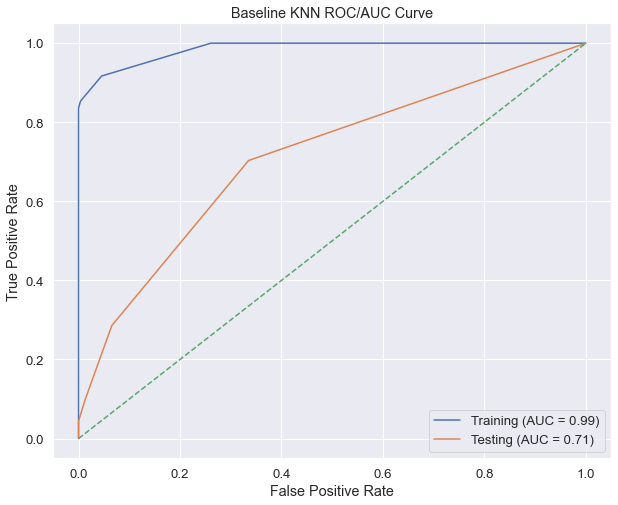

In [7]:
# output ROC/AUC curve
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(knn, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(knn, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title("Baseline KNN ROC/AUC Curve")
plt.show()

The performance of our baseline model is pretty terrible, we can see that very optimistic results for our training data, however, our testing results show sub-par results. Our testing f1-score is at 16%, whereas our training f1-score is around 92%, this is a serious case of over-fitting, and we'll have to optimize our model to counteract this. 

## Hyper Parameter Tuning - F1 Measure

We'll optimize our model to balance between precision and recall.

In [8]:
# create paramter grid and create grid search
param_grid = {
    "n_neighbors": np.arange(1, 102, 2),
    "p": np.linspace(2, 5, 4)
}

rand_search = RandomizedSearchCV(KNeighborsClassifier(), param_grid, n_iter=25, scoring="f1", n_jobs=-1, random_state=SEED)
rand_search.fit(X_train, y_train)

# predictions
train_pred = rand_search.predict(X_train)
test_pred = rand_search.predict(X_test)

In [9]:
# output training & testing results
a = praf1(y_train, train_pred, name="Training")
b = praf1(y_test, test_pred, name="Testing")
display(pd.concat([a, b]))
print(rand_search.best_params_)

,precision,recall,accuracy,f1
Training,0.995588,0.844666,0.920462,0.913939
Testing,0.555556,0.054945,0.856000,0.100000


{'p': 4.0, 'n_neighbors': 7}


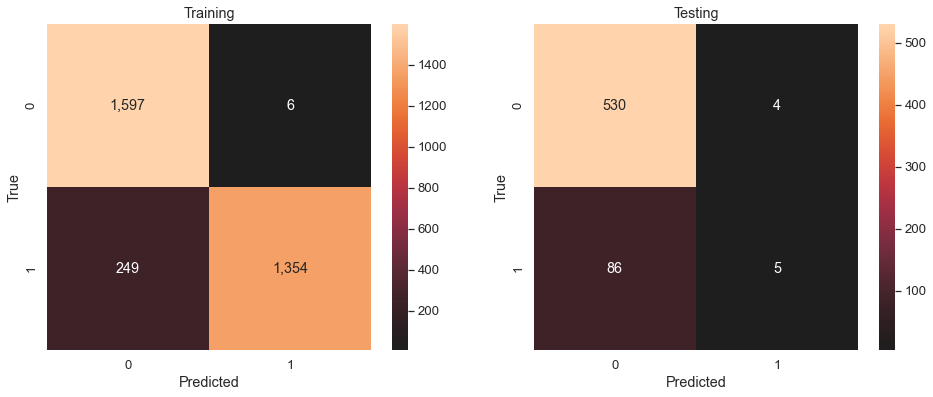

In [10]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

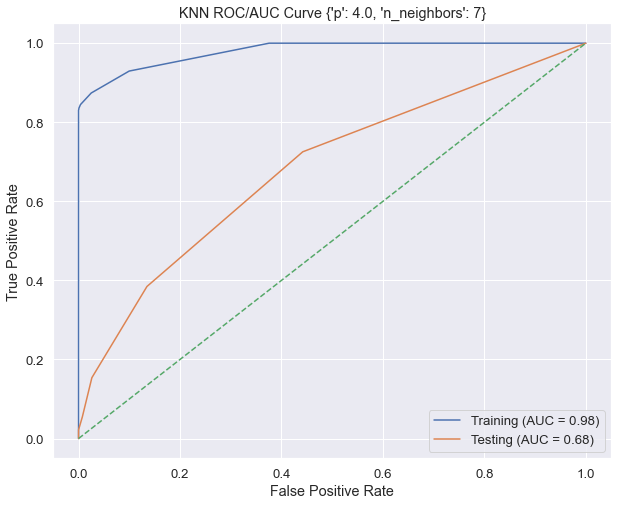

In [11]:
# output ROC/AUC curve
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(rand_search, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rand_search, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title(f"KNN ROC/AUC Curve {rand_search.best_params_}")
plt.show()

Tuning for f1, has resulted in a model which still does not perform well. Our f1 score for the testing data set is 10%, Granted we have not done a complete exhaustive search over the complete parameter space, as the computational time required would be too great. We could in the future look into using higher values for leaf size, but this would come with a hit to accuracy of choosing neighbors.

## Hyper Parameter Tuning - Recall

Tuning for f1 score has resulted in a not so great model this time we'll tune for recall, and see if we can identify a better model.

In [12]:
# create paramter grid and create grid search
param_grid = {
    "n_neighbors": np.arange(1, 102, 2),
    "p": [2, 3]
}

rand_search2 = RandomizedSearchCV(KNeighborsClassifier(), param_grid, n_iter=25, scoring="recall", n_jobs=-1, random_state=SEED)
rand_search2.fit(X_train, y_train)

# predictions
train_pred = rand_search2.predict(X_train)
test_pred = rand_search2.predict(X_test)

In [13]:
# output training & testing results
a = praf1(y_train, train_pred, name="Training")
b = praf1(y_test, test_pred, name="Testing")
display(pd.concat([a, b]))
print(rand_search2.best_params_)

,precision,recall,accuracy,f1
Training,0.507472,0.995633,0.51466,0.672283
Testing,0.147541,0.989011,0.16640,0.256776


{'p': 3, 'n_neighbors': 99}


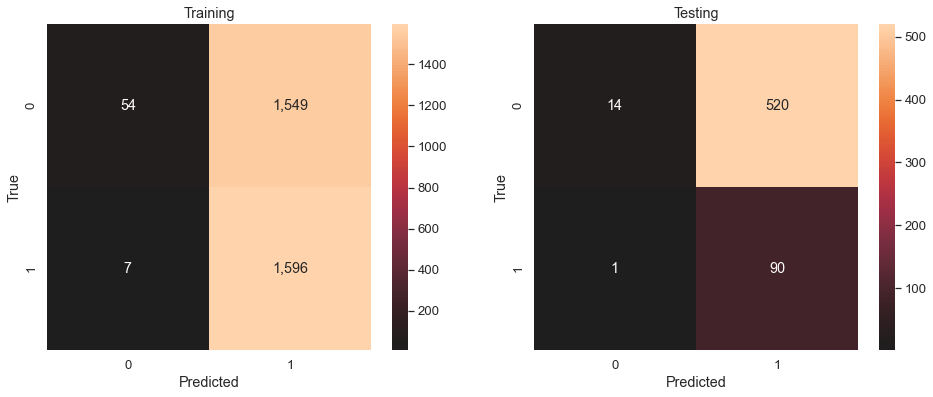

In [14]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])
plt.show()

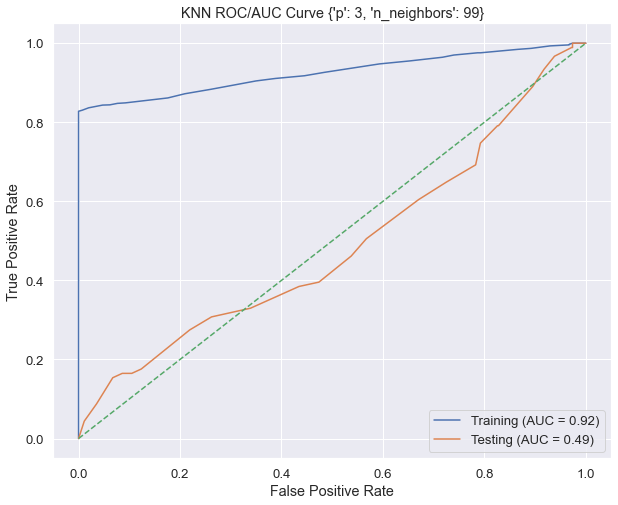

In [15]:
# output ROC/AUC curve
fig, ax = plt.subplots(figsize=(10, 8))
plot_roc_curve(rand_search2, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rand_search2, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.title(f"KNN ROC/AUC Curve {rand_search2.best_params_}")
plt.show()

Our second model which optimizes for recall fares worse than our previous two models. Although the model has an extremely high recall it is at the cost of an extremely low precision. The result is a model with very poor f1 score. 

Looking at the ROC curve, we can see that compared to random guessing our model fares worse. In fact, it appears as if our model simply predicts each datum as positive, explaining why it has such a high recall.

## Final Testing

In [16]:
# import testing data
test = pd.read_csv("../data/processed/test.csv")

X = test.iloc[:, :-1]
y = test.iloc[:, -1]

pred = rand_search.predict(X)

In [17]:
# output test results
praf1(y, pred, "Final Testing")

,precision,recall,accuracy,f1
Final Testing,0.6,0.024793,0.856115,0.047619


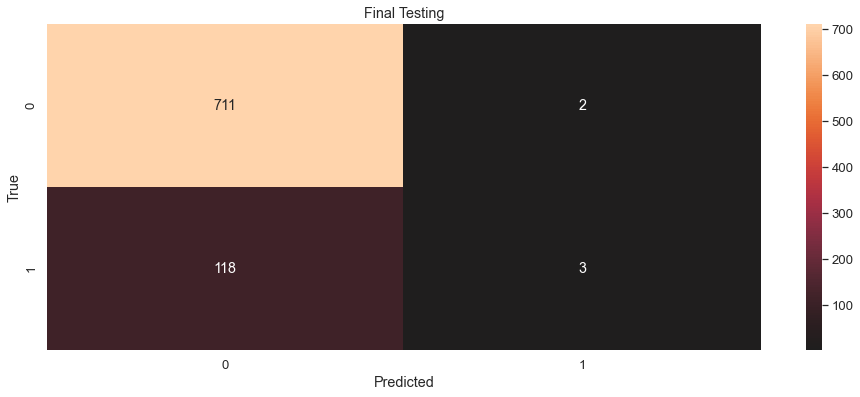

In [18]:
# output confusion matrix of results
confmat([y], [pred], ["Final Testing"])
plt.show()

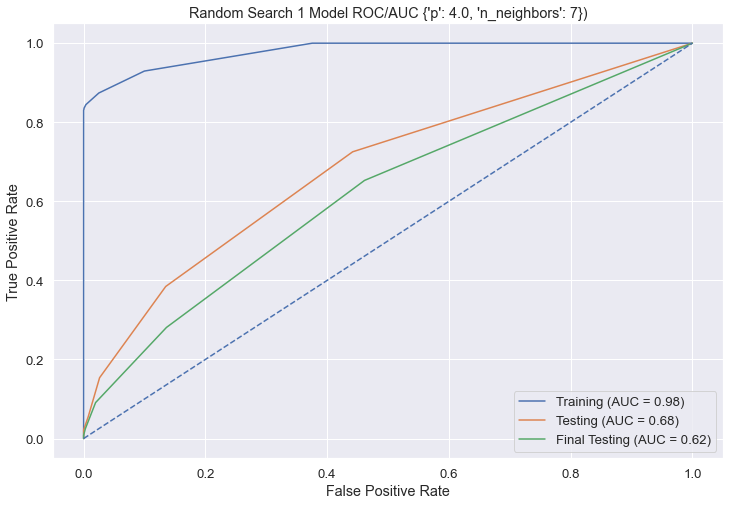

In [19]:
# output ROC curve and auc for our model
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(rand_search, X_train, y_train, ax=ax, name="Training")
plot_roc_curve(rand_search, X_test, y_test, ax=ax, name="Testing")
plot_roc_curve(rand_search, X, y, ax=ax, name="Final Testing")

line = np.linspace(0, 1)
plt.plot(line, line, "b--")

plt.title(f"Random Search 1 Model ROC/AUC {rand_search.best_params_})")
plt.show()